In [6]:
"""
Extended kalman filter (EKF) localization sample
author: Atsushi Sakai (@Atsushi_twi)
"""
!matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt

# Estimation parameter of EKF
Q = np.diag([0.1, 0.1, math.radians(1.0), 1.0])**2
R = np.diag([1.0, math.radians(40.0)])**2

#  Simulation parameter
Qsim = np.diag([0.5, 0.5])**2
Rsim = np.diag([1.0, math.radians(30.0)])**2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_animation = True


def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.matrix([v, yawrate]).T
    return u


def observation(xTrue, xd, u):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    zx = xTrue[0, 0] + np.random.randn() * Qsim[0, 0]
    zy = xTrue[1, 0] + np.random.randn() * Qsim[1, 1]
    z = np.matrix([zx, zy])

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):

    F = np.matrix([[1.0, 0, 0, 0],
                   [0, 1.0, 0, 0],
                   [0, 0, 1.0, 0],
                   [0, 0, 0, 0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT],
                   [1.0, 0.0]])

    x = F * x + B * u

    return x


def observation_model(x):
    #  Observation Model
    H = np.matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H * x

    return z


def jacobF(x, u):
    """
    Jacobian of Motion Model
    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.matrix([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF


def jacobH(x):
    # Jacobian of Observation Model
    jH = np.matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH


def ekf_estimation(xEst, PEst, z, u):

    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacobF(xPred, u)
    PPred = jF * PEst * jF.T + Q

    #  Update
    jH = jacobH(xPred)
    zPred = observation_model(xPred)
    y = z.T - zPred
    S = jH * PPred * jH.T + R
    K = PPred * jH.T * np.linalg.inv(S)
    xEst = xPred + K * y
    PEst = (np.eye(len(xEst)) - K * jH) * PPred

    return xEst, PEst


def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.matrix([[math.cos(angle), math.sin(angle)],
                   [-math.sin(angle), math.cos(angle)]])
    fx = R * np.matrix([x, y])
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

/bin/sh: matplotlib: command not found


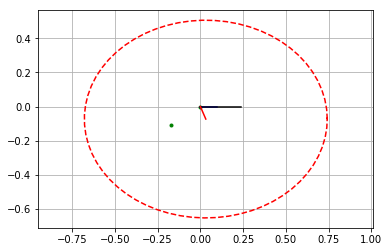

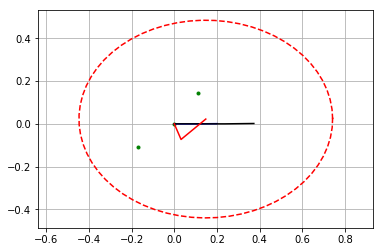

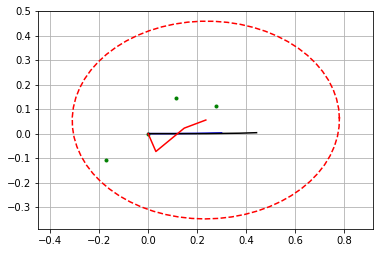

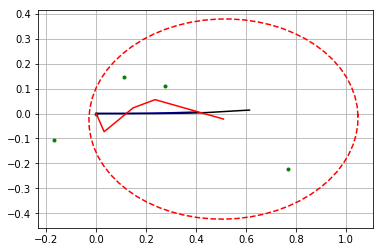

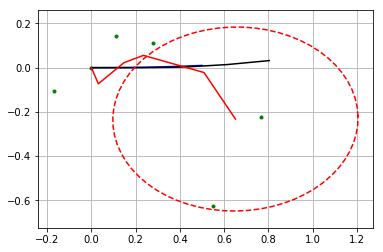

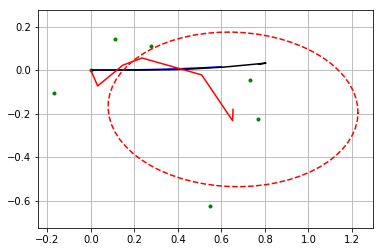

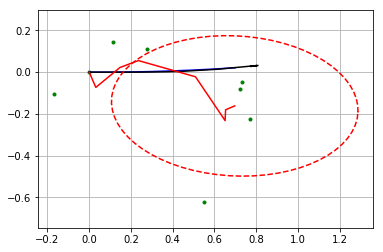

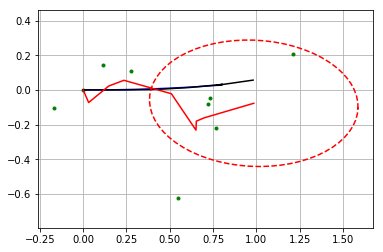

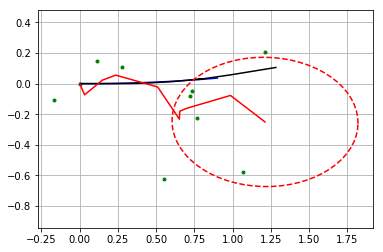

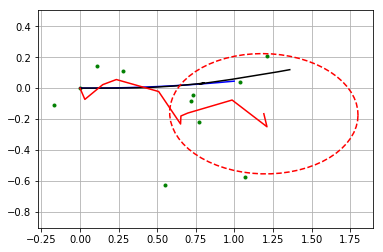

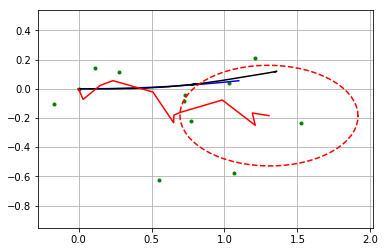

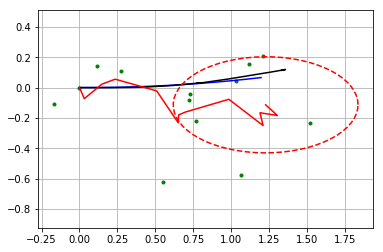

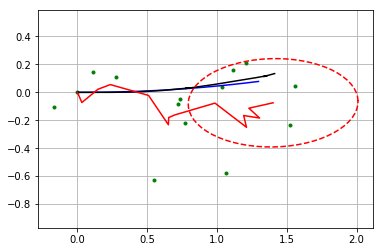

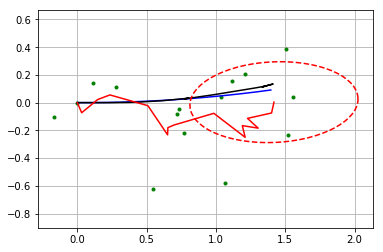

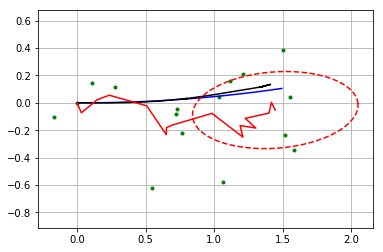

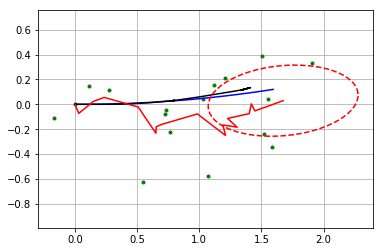

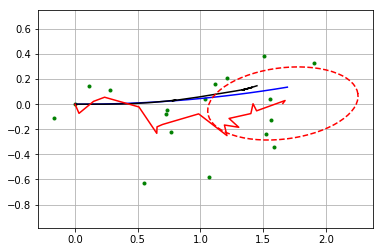

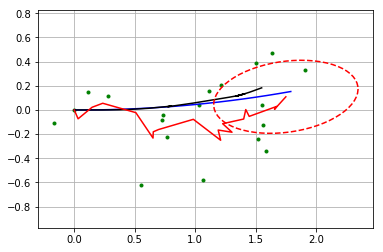

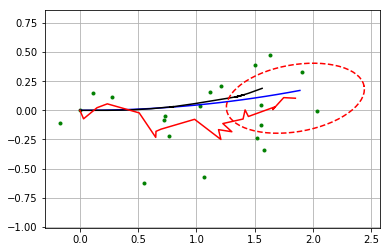

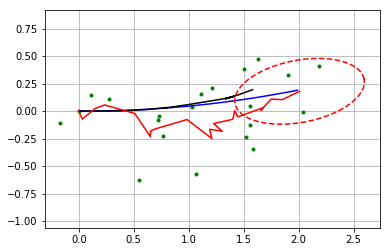

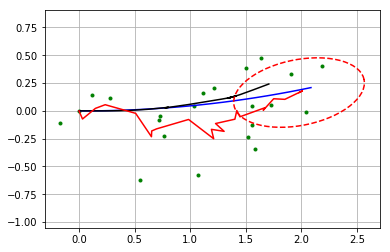

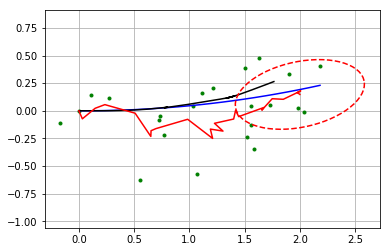

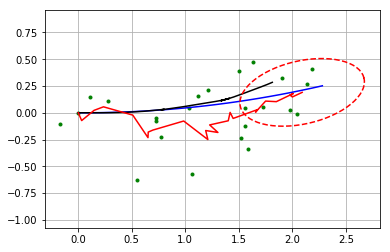

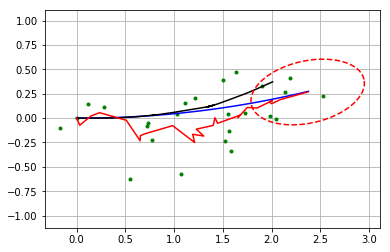

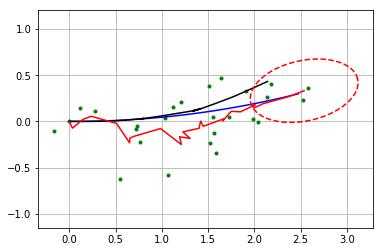

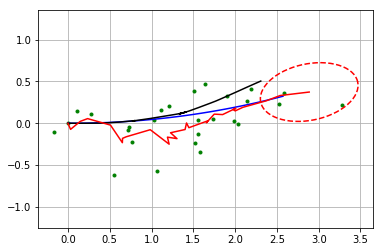

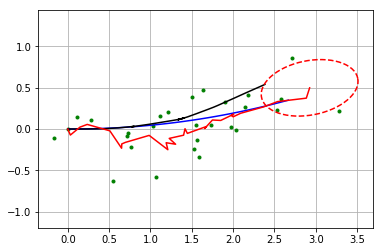

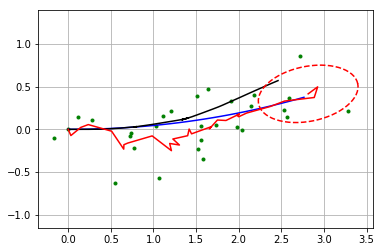

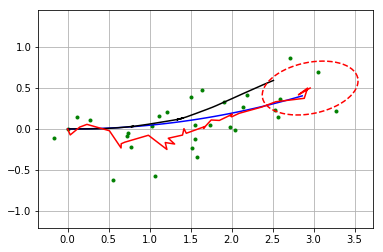

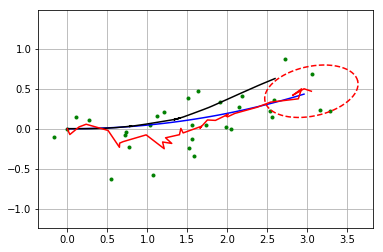

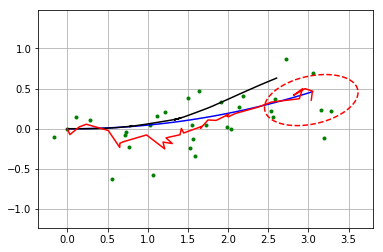

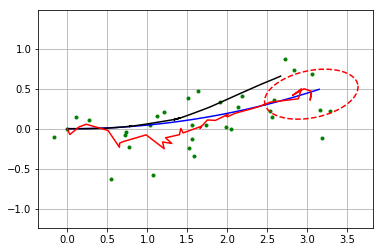

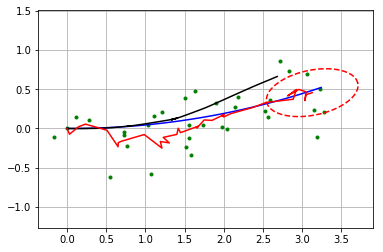

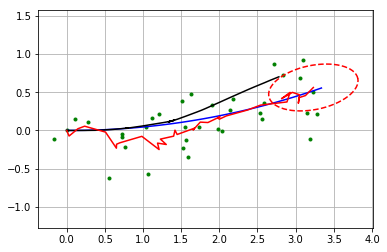

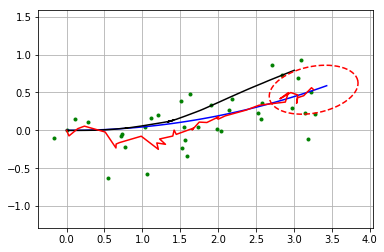

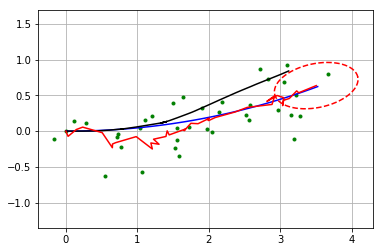

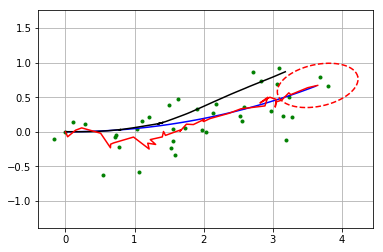

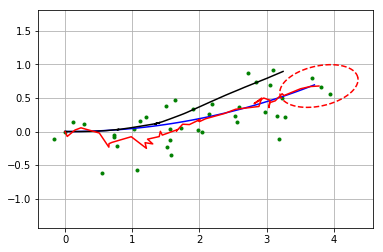

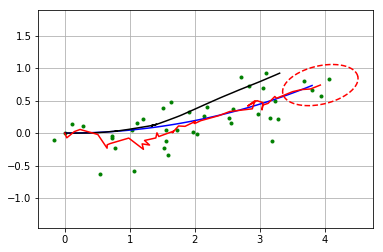

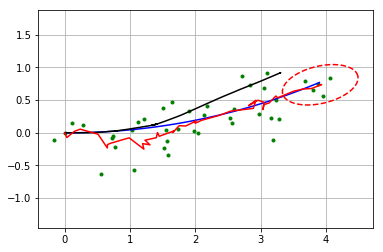

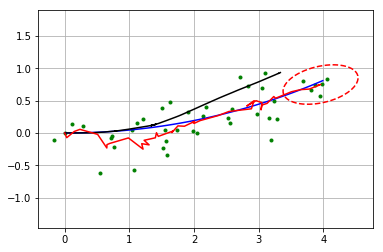

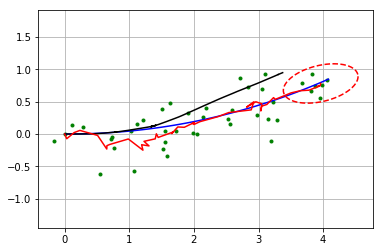

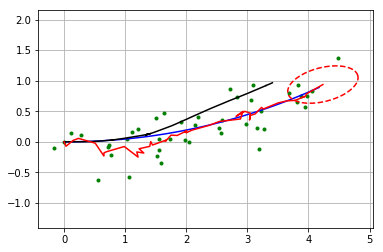

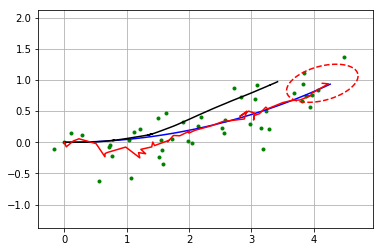

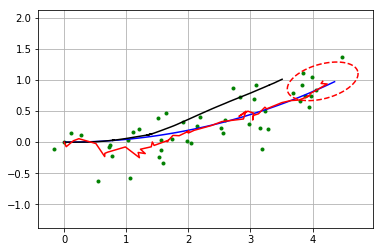

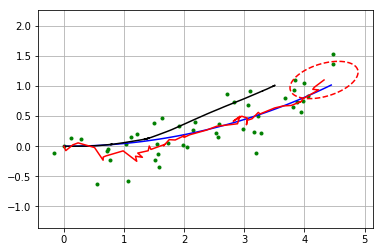

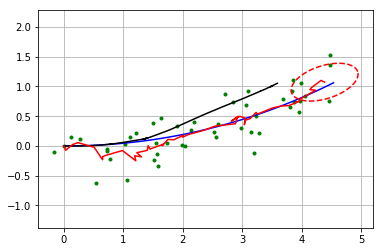

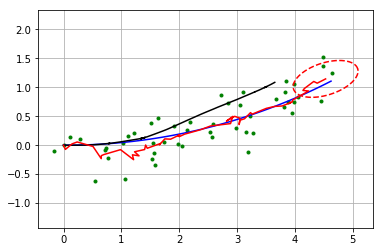

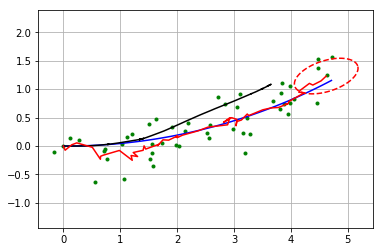

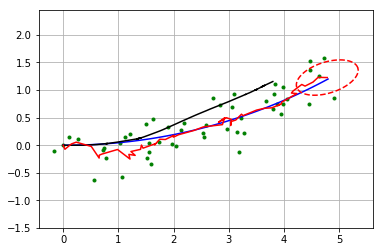

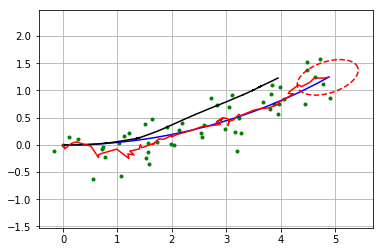

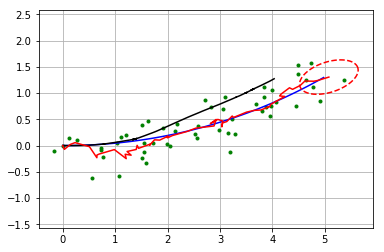

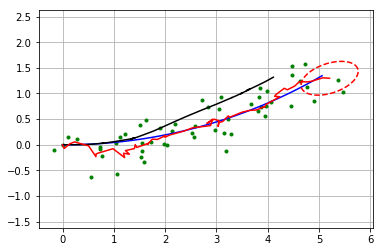

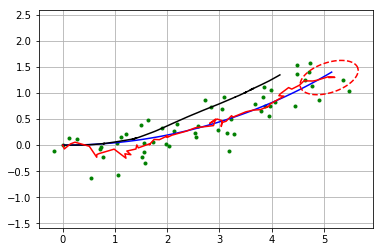

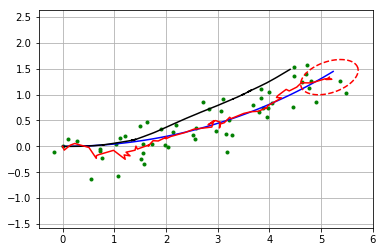

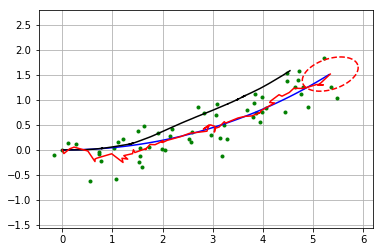

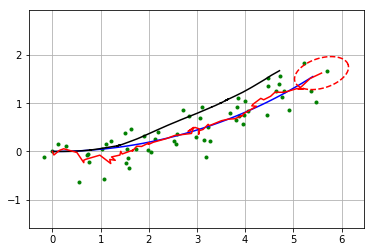

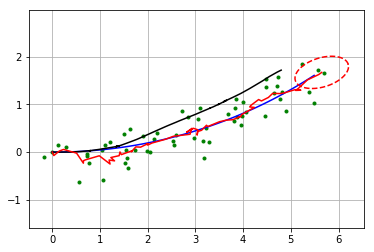

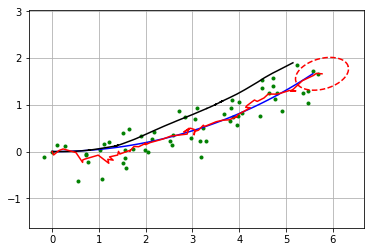

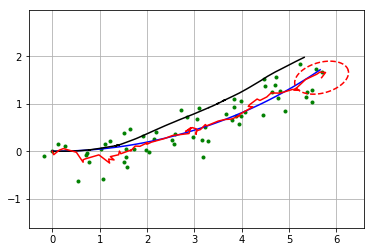

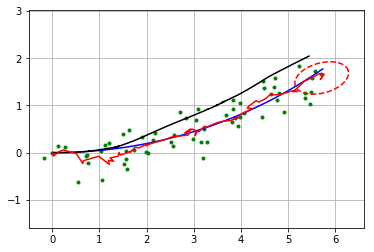

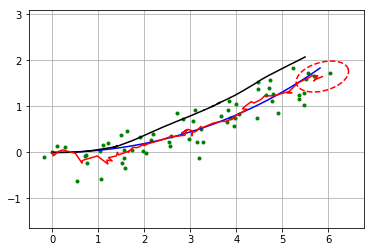

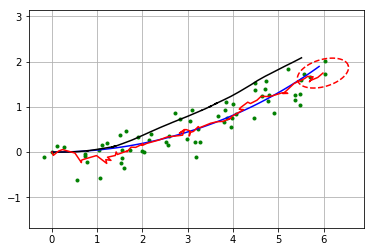

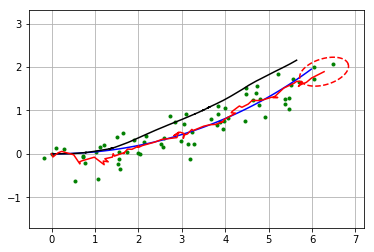

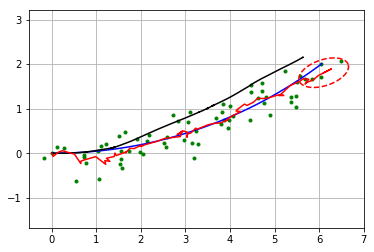

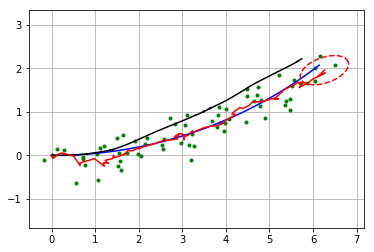

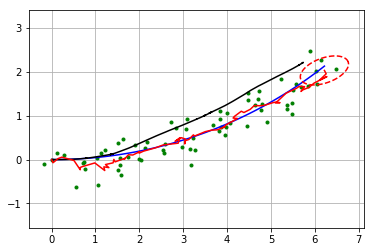

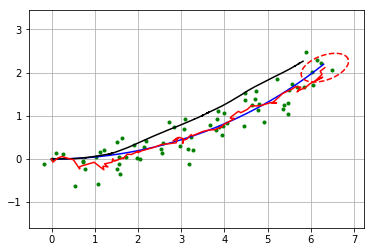

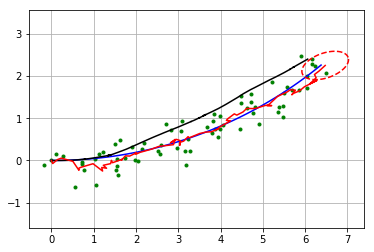

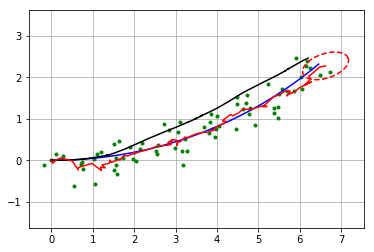

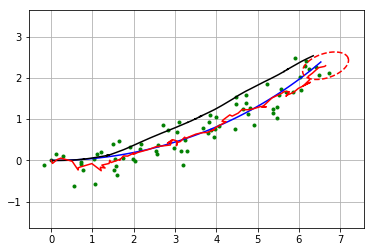

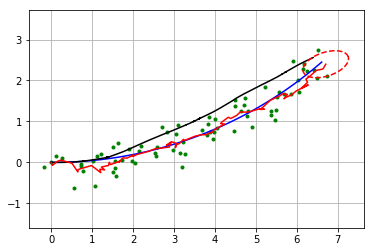

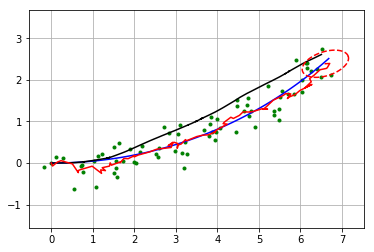

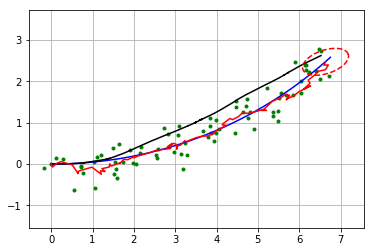

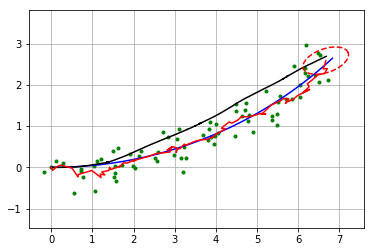

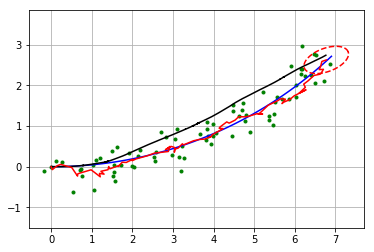

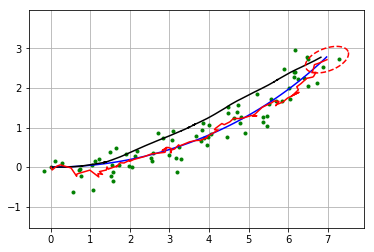

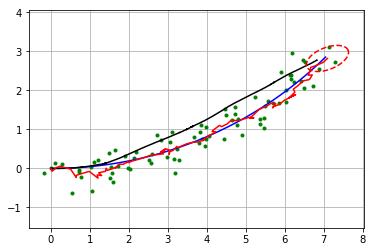

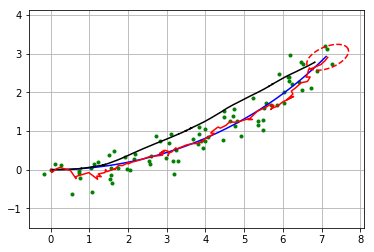

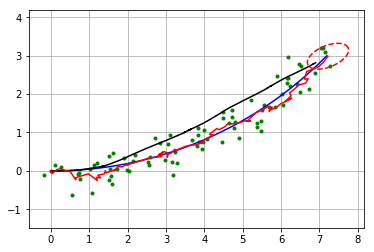

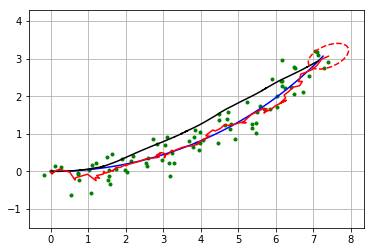

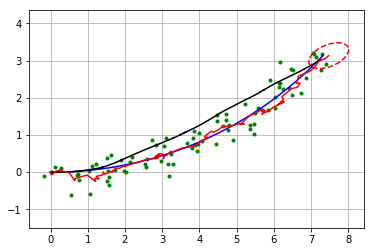

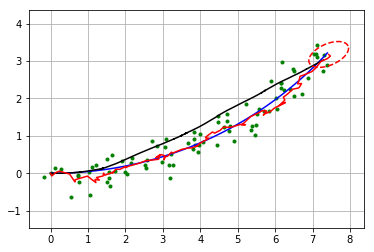

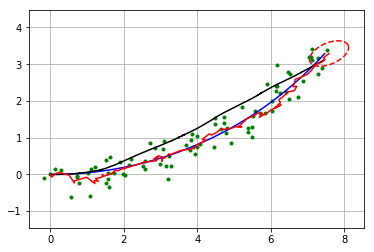

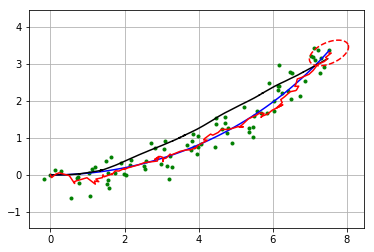

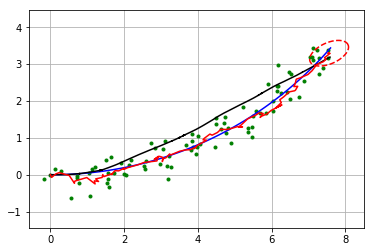

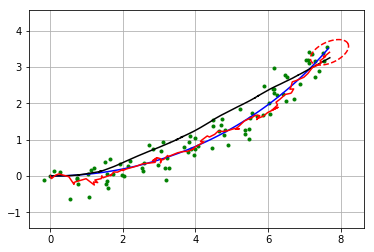

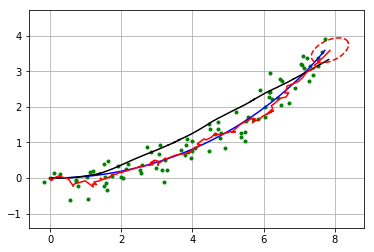

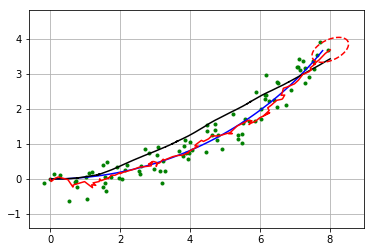

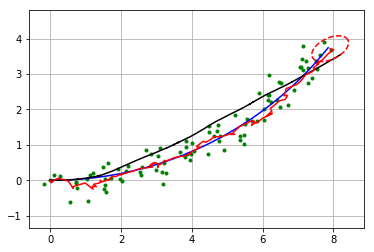

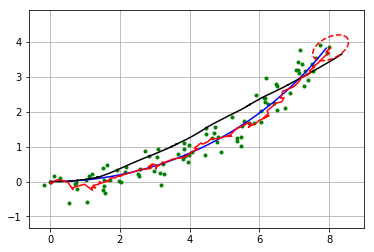

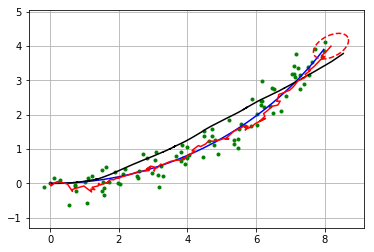

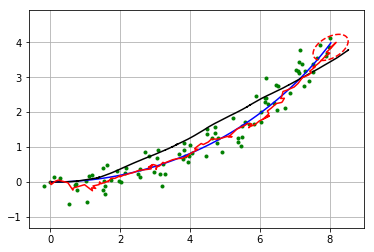

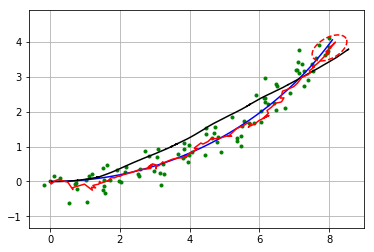

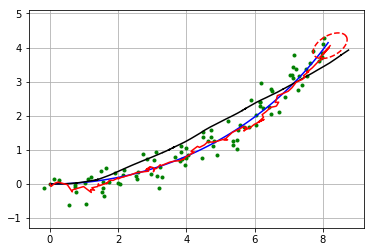

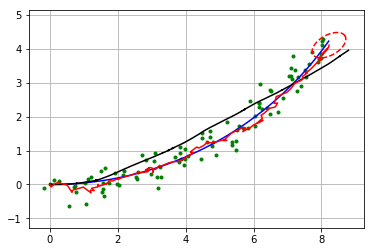

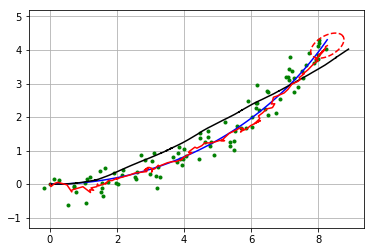

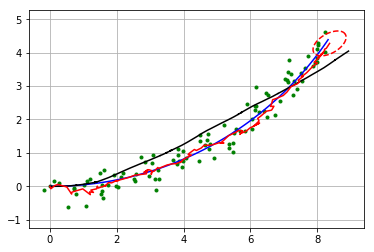

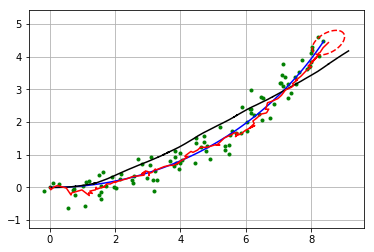

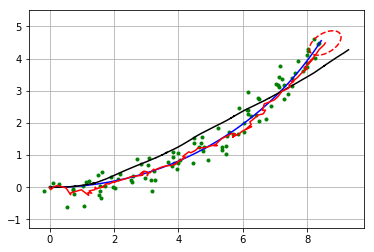

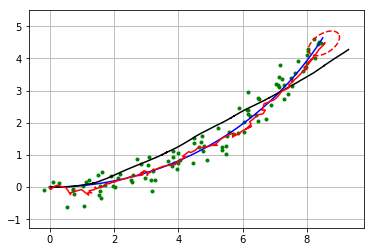

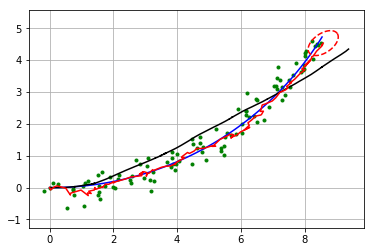

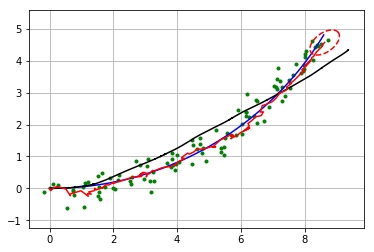

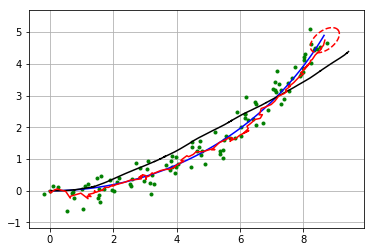

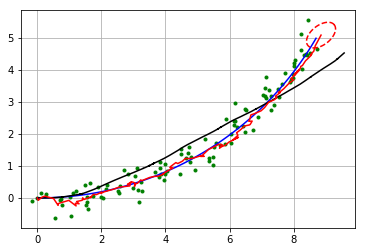

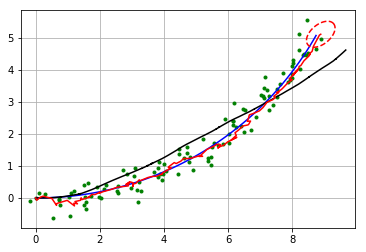

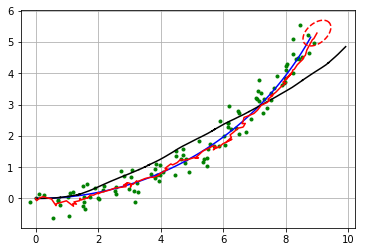

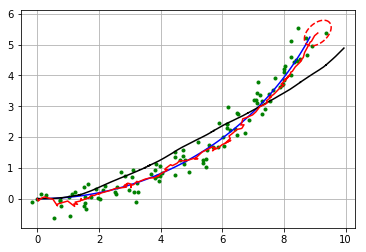

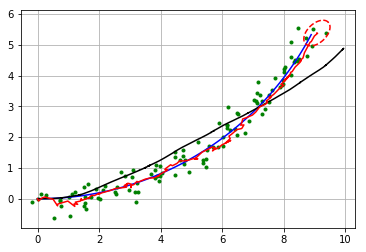

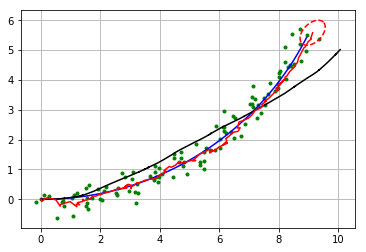

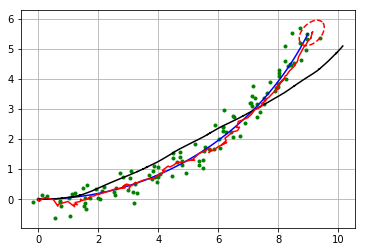

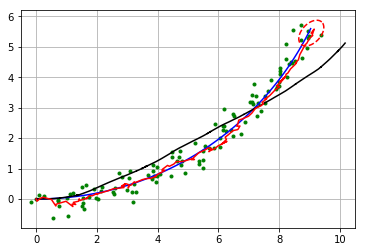

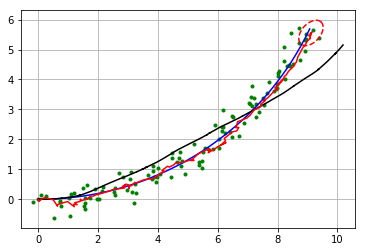

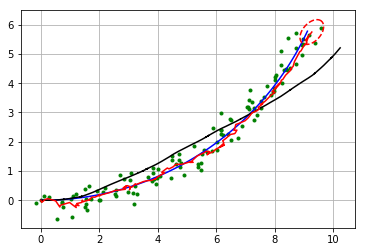

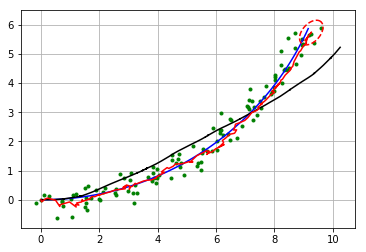

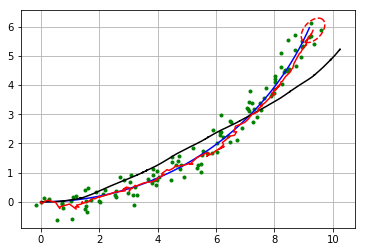

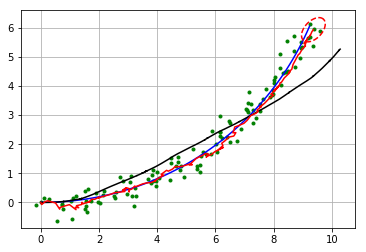

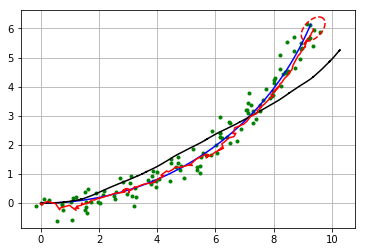

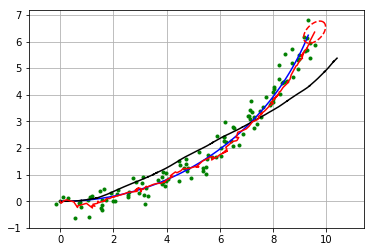

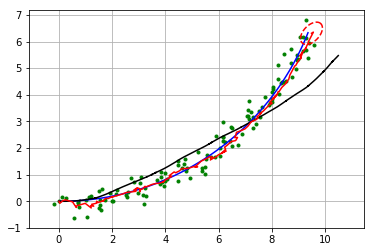

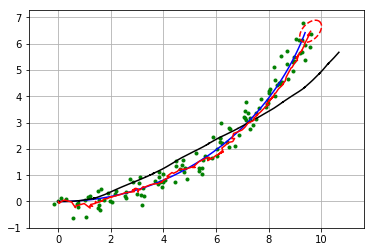

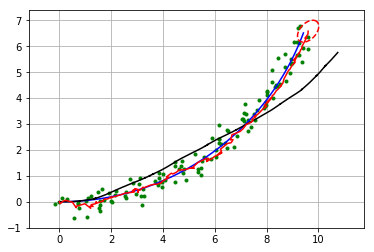

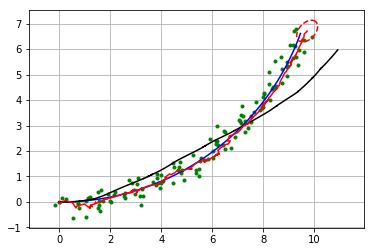

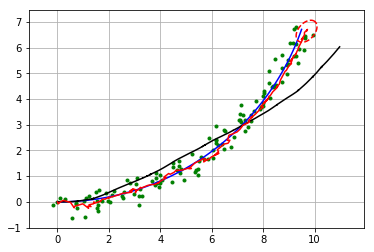

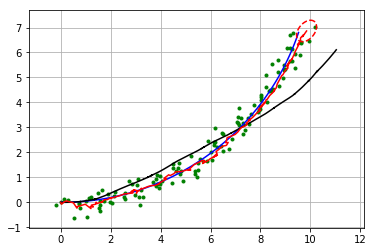

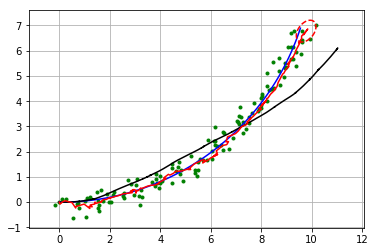

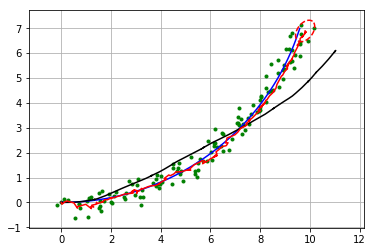

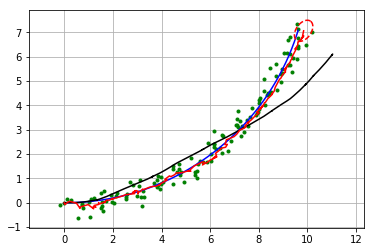

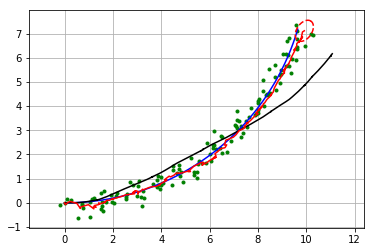

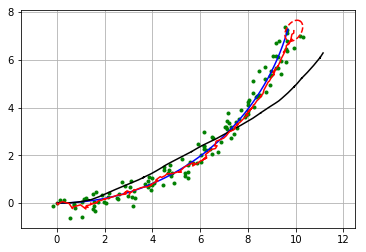

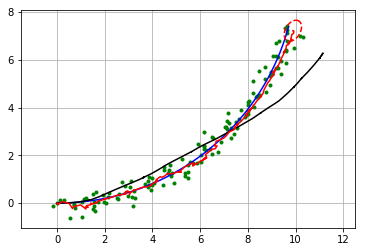

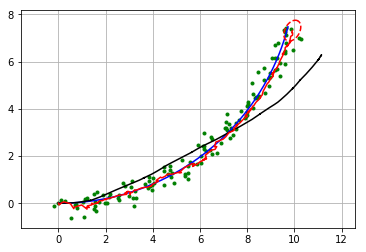

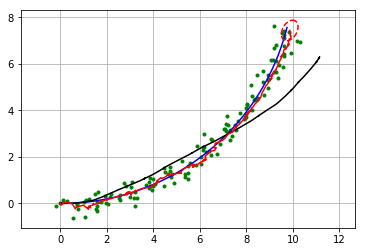

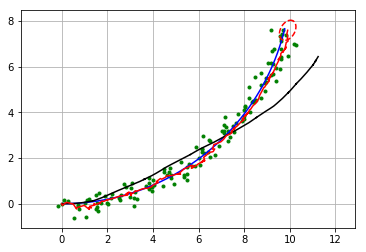

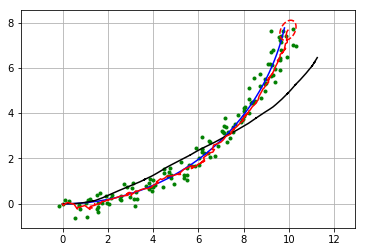

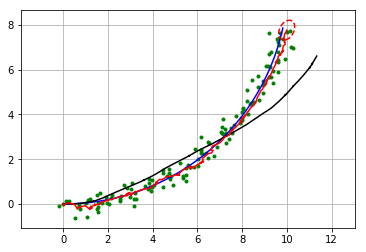

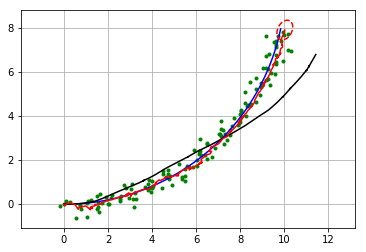

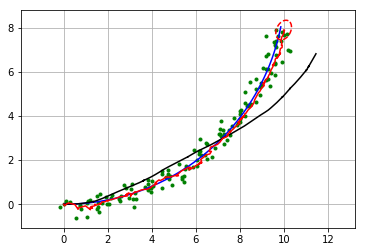

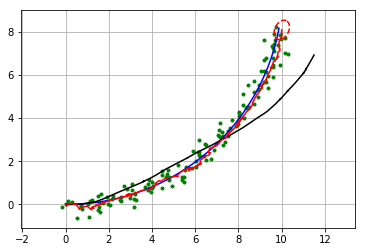

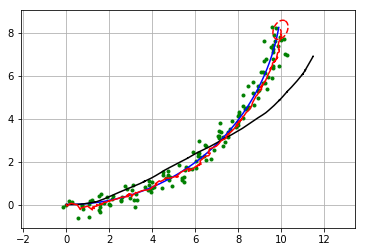

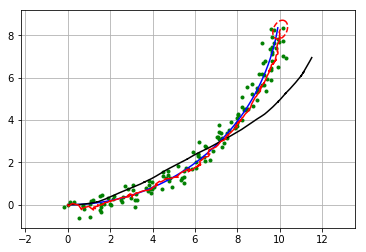

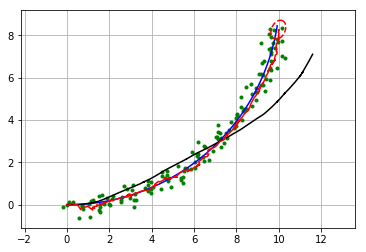

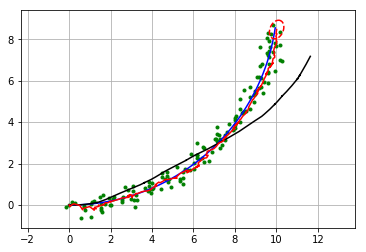

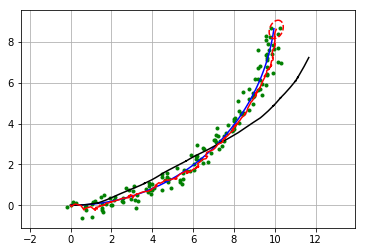

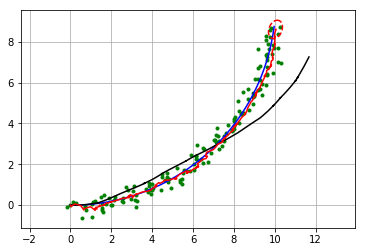

KeyboardInterrupt: 

In [7]:


time = 0.0

# State Vector [x y yaw v]'
xEst = np.matrix(np.zeros((4, 1)))
xTrue = np.matrix(np.zeros((4, 1)))
PEst = np.eye(4)

xDR = np.matrix(np.zeros((4, 1)))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((1, 2))

while SIM_TIME >= time:
    time += DT
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.vstack((hz, z))

    if show_animation:
        plt.cla()
        plt.plot(hz[:, 0], hz[:, 1], ".g")
        plt.plot(np.array(hxTrue[0, :]).flatten(),
                 np.array(hxTrue[1, :]).flatten(), "-b")
        plt.plot(np.array(hxDR[0, :]).flatten(),
                 np.array(hxDR[1, :]).flatten(), "-k")
        plt.plot(np.array(hxEst[0, :]).flatten(),
                 np.array(hxEst[1, :]).flatten(), "-r")
        plot_covariance_ellipse(xEst, PEst)
        plt.axis("equal")
        plt.grid(True)
        plt.pause(0.001)